In [1]:
import pandas as pd
from pyspark import SparkContext
import time
import numpy as np
from pyspark.sql import SparkSession

In [2]:
sc = SparkContext("local[*]", "UserUserRating")
spark = SparkSession(sc)

In [6]:
selected_city = "MESA"
selected_state = "AZ"


reviews_df =spark.read.json('/Users/monisha/Desktop/USC/ThirdSemester/CSCI541-DataMining/Project/yelp_dataset/yelp_academic_dataset_review.json')
business_df =spark.read.json('/Users/monisha/Desktop/USC/ThirdSemester/CSCI541-DataMining/Project/yelp_dataset/yelp_academic_dataset_business.json')
users_df =spark.read.json('/Users/monisha/Desktop/USC/ThirdSemester/CSCI541-DataMining/Project/yelp_dataset/yelp_academic_dataset_user.json')

businesses_in_arizona = business_df.where(business_df.state==selected_state)
business_to_review_df= businesses_in_arizona.join(reviews_df,businesses_in_arizona.business_id==reviews_df.business_id,"left_outer")
business_filtr_city=business_to_review_df.groupBy('city').count()
business_filtr_city.orderBy('count' , ascending=0).show()


+---------------+------+
|           city| count|
+---------------+------+
|        Phoenix|659878|
|     Scottsdale|351158|
|          Tempe|182610|
|           Mesa|154278|
|       Chandler|141090|
|        Gilbert|114409|
|       Glendale| 88969|
|         Peoria| 50969|
|       Surprise| 30448|
|       Goodyear| 25169|
|       Avondale| 19578|
|     Cave Creek| 11554|
| Fountain Hills|  6375|
|Litchfield Park|  6195|
|Paradise Valley|  4737|
|        Buckeye|  4646|
|           MESA|  4132|
|       Sun City|  3130|
|       Tolleson|  2773|
|         Laveen|  2668|
+---------------+------+
only showing top 20 rows



In [7]:
businesses_in_arizona=businesses_in_arizona.withColumnRenamed("name", "business_name").withColumnRenamed("stars", "business_stars").withColumnRenamed("review_count", "business_review_count")
reviews_df = reviews_df.withColumnRenamed("stars", "reviews_star").withColumnRenamed("cool", "reviews_cool").withColumnRenamed("funny", "reviews_funny").withColumnRenamed("useful", "reviews_useful")
business_to_review_df= businesses_in_arizona.join(reviews_df,businesses_in_arizona.business_id==reviews_df.business_id,"left_outer").drop(reviews_df.business_id)


In [9]:
city_df = business_to_review_df.where(business_to_review_df.city==selected_city)
city_df.select("user_id", "business_id","reviews_star").toPandas().to_csv(selected_city+".csv")

In [10]:
trainData =sc.textFile(selected_city+".csv")
trainDataFirst = trainData.first()
trainData = trainData.filter(lambda x: x!= trainDataFirst)
trainData = trainData.map(lambda l: l.split(','))
trainData = trainData.map(lambda x : (x[1],x[2],x[3])).collect()

In [11]:
users = {}
businesses = {}
finalInput = []
ratings = []

In [12]:
for i in trainData:
    if users.get(i[0]) is None:
        users[i[0]] = len(users) + 1
    if businesses.get(i[1]) is None:
        businesses[i[1]] = len(businesses) + 1
    ratings.append(float(i[2].strip()))
    finalInput.append([users[i[0]],businesses[i[1]],float(i[2].strip())])

In [13]:
invUsers = {str(v): k for k, v in users.items()}
invBusinesses = {str(v): k for k, v in businesses.items()}

trainAvgRating = [float(sum(col))/len(col) for col in zip(*finalInput)][2]
minVal = min(ratings)
maxVal = max(ratings)


In [14]:
finalTrainInput = sc.parallelize(finalInput)

userAverage = finalTrainInput.map(lambda l: (l[0], l[2])).mapValues(lambda l: (l,1)).reduceByKey(lambda x,y: (x[0] + y[0], x[1] + y[1]))
userAverage = userAverage.mapValues(lambda l: 1.0*l[0]/l[1]).collectAsMap()

businesAverage = finalTrainInput.map(lambda l: (l[1], l[2])).mapValues(lambda l: (l,1)).reduceByKey(lambda x,y: (x[0] + y[0], x[1] + y[1]))
businesAverage = businesAverage.mapValues(lambda l: 1.0*l[0]/l[1]).collectAsMap()

In [15]:
trainRdd = finalTrainInput
trainRddUsers = trainRdd.map(lambda x : ((str(x[0]), str(x[1])), (float(x[2])-minVal)/(maxVal-minVal)))
trainingRddUsers = trainRddUsers.map(lambda x : (x[0][0], (x[0][1], x[1])))
businessesOnlyUserCF = trainingRddUsers.map(lambda x : (x[1][0], x[0]))
businessesOnlyUserCF = businessesOnlyUserCF.groupByKey()
businessesOnlyUserCF = businessesOnlyUserCF.mapValues(list)
businessesOnlyUserCF = businessesOnlyUserCF.collectAsMap()
userAndBusinessesUserCF = trainingRddUsers.map(lambda x : ((x[0], x[1][0]), x[1][1]))
userAndBusinessesUserCF = userAndBusinessesUserCF.collectAsMap()

usersOnlyUserCF = trainingRddUsers.groupByKey()
usersOnlyUserCF = usersOnlyUserCF.mapValues(list)
usersOnlyUserCF = usersOnlyUserCF.collectAsMap()

In [16]:
def calcPearsonUsers(corratedUsersBusinessess):
    if len(corratedUsersBusinessess) == 0:
        return -100
    tempUB = [x[1][0] for x in corratedUsersBusinessess]
    tempUBAvg = sum(tempUB)/len(tempUB)
    pearsonNumerator = 0
    pearsonDenom1 = 0
    pearsonDenom2 = 0
    allUB = [x[1][1] for x in corratedUsersBusinessess]
    for (i, j) in zip(tempUB, allUB):
        pearsonNumerator += (i-tempUBAvg)*(j-tempUBAvg)
        pearsonDenom1 += (i-tempUBAvg)**2
        pearsonDenom2 += (j-tempUBAvg)**2
    pearsonDenom = (pearsonDenom1**0.5) * (pearsonDenom2**0.5)
    if pearsonDenom == 0 or pearsonNumerator == 0:
        return -100
    else:
        return pearsonNumerator/pearsonDenom

In [17]:
user_ids = usersOnlyUserCF.keys()

In [18]:
user_vs_business ={}
import pandas as pd
for k , v in usersOnlyUserCF.items():
    user_vs_business [k] =  len(v)
data = {"user" : list(user_vs_business.keys()) , "count_business" : list(user_vs_business.values())}
df=pd.DataFrame.from_dict(data)

In [19]:
user_ids=list(user_ids)

In [20]:
pearson_between_users= []

In [21]:
for i,user1 in enumerate(user_ids[:-1]):
    for j , user2 in enumerate(user_ids[i+1:]):
        eachUserInfo = usersOnlyUserCF[user1]
        tempKnnUsersInfo = usersOnlyUserCF[user2]
        corratedUsersBusinessess = []
        tempKnnUsersInfo.sort()
        eachUserInfo.sort()
        l= 0
        k = 0
        while l<len(tempKnnUsersInfo) and k< len(eachUserInfo):
            if tempKnnUsersInfo[l][0] == eachUserInfo[k][0]:
                corratedUsersBusinessess.append((tempKnnUsersInfo[l][0], (tempKnnUsersInfo[l][1], eachUserInfo[k][1])))
                l = l+1
                k = k+1
            elif tempKnnUsersInfo[l][0] < eachUserInfo[k][0]:
                l = l+1
            else:
                k = k+1
       
        pearsonRating = calcPearsonUsers(corratedUsersBusinessess)
        if pearsonRating != -100:
            pearson_between_users.append((user1,user2,pearsonRating))

In [22]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
spark = SparkSession(sc)

In [23]:
pearson_rdd = sc.parallelize(pearson_between_users)

# convert to code and Use below to dump user-user pearson to file

In [24]:
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt

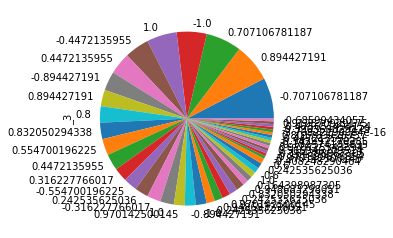

In [25]:
pearson_rdd=pearson_rdd.toDF()
pearson_df=pearson_rdd.toPandas()
pearson_df.count()
pearson_df["_3"].value_counts().plot.pie()
plt.gca().set_aspect("equal")

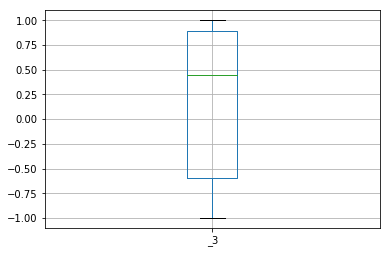

In [26]:
boxplot = pearson_df.boxplot(column=["_3"])

In [27]:
data = pearson_df[pearson_df._3 > 0 ]
G = nx.from_pandas_edgelist(data, "_1", "_2", ["_3"])

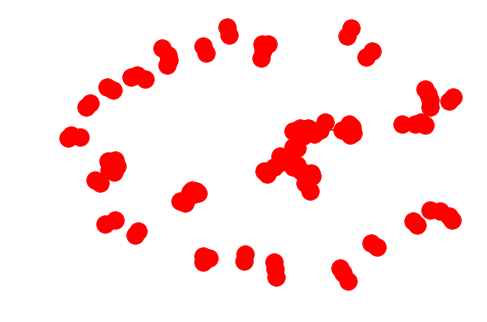

In [28]:
nx.draw(G)
plt.show()

In [29]:
nx.classes.function.density(G)

0.021097834204630322

In [32]:
comp = nx.algorithms.community.centrality.girvan_newman(G)
cnt=0
d={}
e={}

for c in next(comp):
    d[cnt]=len(c)
    e[cnt]=c
    cnt+=1
print("number of communities: "+str(cnt)) 
print("community : number_of_users")
print(d)

number of communities: 28
community : number_of_users
{0: 4, 1: 24, 2: 2, 3: 4, 4: 2, 5: 3, 6: 8, 7: 2, 8: 5, 9: 3, 10: 4, 11: 2, 12: 2, 13: 6, 14: 2, 15: 2, 16: 2, 17: 2, 18: 4, 19: 2, 20: 2, 21: 3, 22: 2, 23: 3, 24: 2, 25: 3, 26: 2, 27: 2}


In [34]:
community_users_dict = {}

user_community_dict={}
for i in e:
    usersList = []
    for j in range(len(e[i])):
        user_community_dict[invUsers[list(e[i])[j]]] = i
        usersList.append(invUsers[list(e[i])[j]])
    community_users_dict[i] = usersList

In [35]:
user_community_df = pd.DataFrame.from_dict({"user_id" : list(user_community_dict.keys()) , "community" :  list(user_community_dict.values())})

In [36]:
user_data=pd.read_csv('/Users/monisha/Desktop/USC/ThirdSemester/CSCI541-DataMining/Project/users_from_arizona.csv')
user_df=user_data.filter(['user_id', 'friends'], axis=1)

In [37]:
first_comm=next(comp)

In [40]:
import operator
max_count_community = max(d.iteritems(), key=operator.itemgetter(1))[0]

In [41]:
first_comm_list=list(first_comm[max_count_community])
first_comm_list

[u'295',
 u'301',
 u'665',
 u'488',
 u'363',
 u'340',
 u'341',
 u'464',
 u'372',
 u'274',
 u'337',
 u'268',
 u'222',
 u'1566']

In [42]:
test_user= invUsers[first_comm_list[0]]

In [43]:
first_comm_user_id_list = [ invUsers[i] for i in first_comm_list]


In [44]:
user_features = pd.read_csv("/Users/monisha/Desktop/USC/ThirdSemester/CSCI541-DataMining/Project/user_business_rating_49k_features_added.csv")

user_features =user_features.groupby(['user_id','business_reviewed_count', 'average_stars', 'compliment_cool' ,'compliment_cute' , 'compliment_funny', 'compliment_hot', 'compliment_list','compliment_more','funny','compliment_note','fans','friends_count','elite_count','cool','compliment_photos','compliment_writer','compliment_profile','compliment_plain', 'review_count','useful','yelping_since_years']).size().reset_index().rename(columns={0:'count'})

In [46]:
user_community_df_full= user_community_df.merge(user_features, left_on="user_id" ,right_on="user_id",how="inner")

In [47]:
user_community_df_full

,community,user_id,business_reviewed_count,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,...,elite_count,cool,compliment_photos,compliment_writer,compliment_profile,compliment_plain,review_count,useful,yelping_since_years,count
0,11,eM8SBU6MTncWKINXVc_icQ,19,4.00,0,0,0,0,0,0,...,0,0,0,0,0,0,21,3,6.0,18
1,1,c5DwPN8vdH-Q1wid7xDD_w,69,4.17,0,0,0,0,0,0,...,2,2,2,0,0,3,83,20,3.0,66
2,1,d2Q8D9ABP0_4qYF0uRuH4g,45,3.82,0,0,0,0,0,0,...,0,0,0,0,0,0,55,2,2.0,42
3,13,jd0Wp6PktCAFmrFzpToAlQ,30,4.05,13,0,13,1,0,0,...,5,1,0,0,0,9,195,16,10.0,22
4,8,xsdqu99Iq7LKXWdA0R3UKg,118,4.39,1,0,1,0,0,0,...,3,0,1,2,0,6,254,3,4.0,111
5,3,URPjW8ckLuLDLR02uuLpTg,389,3.18,24,2,24,7,1,7,...,0,8,6,10,5,58,640,175,7.0,346
6,18,MBWZlm_OqoADm35BNQE6Qw,13,4.36,0,0,0,0,0,1,...,0,1,0,0,0,2,21,11,7.0,11
7,6,XDZaX1izk0aVNaKXLiqhQA,118,2.27,0,0,0,0,0,0,...,0,0,0,0,0,3,153,60,9.0,99
8,15,zHwAyrygwXPtOGr565y7qg,28,4.59,0,0,0,0,0,0,...,0,2,0,0,0,2,39,18,4.0,27
9,5,iBmkeRP7c7juX1U1Ek75IA,33,3.98,0,0,0,0,0,0,...,0,0,0,0,0,0,50,6,7.0,30


In [48]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [49]:
scaler.fit(user_community_df_full.values[:,2:])
user_community_transformed= scaler.transform(user_community_df_full.values[:,2:])

/Users/monisha/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [50]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
array = user_community_transformed
array2 = user_community_df_full
X = array[:,0:]
Y = array[:,0]
Y = Y.astype('int')
model = LogisticRegression()

rfe = RFE(model, 10)
rfe = rfe.fit(X, Y)
# summarize the selection of the attributes
print("Num Features: ", rfe.n_features_)
print("Selected Features: ",rfe.support_)
print("Feature Ranking:",  rfe.ranking_)
names = user_community_df_full.columns.values
a=np.array(names)

selectedFeatures = ['user_id']

f = rfe.support_.tolist()
for i in range(0,len(names[2:])):
    if f[i]==True:
        selectedFeatures.append(names[i+2])
        

('Num Features: ', 10)
('Selected Features: ', array([ True, False, False,  True, False, False, False, False, False,
       False, False,  True,  True, False,  True, False,  True, False,
        True,  True,  True,  True]))
('Feature Ranking:', array([ 1, 12, 13,  1, 11,  2,  7,  4,  5,  9, 10,  1,  1,  6,  1,  8,  1,
        3,  1,  1,  1,  1]))


In [52]:
test_user_features = user_features[user_features.user_id ==test_user]

In [54]:
community_features = user_features[ user_features['user_id'].isin(first_comm_user_id_list)]

In [55]:
community_features_i =community_features.reset_index(drop=True)
community_features_i_new = community_features_i[selectedFeatures]

In [56]:
comm_feat_X =community_features_i_new.values[:,1:]
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(comm_feat_X[:,1:])
comm_feat_X= scaler.transform(comm_feat_X[:,1:])

In [57]:
from sklearn.metrics.pairwise import cosine_similarity
cos_sim = cosine_similarity(community_features_i_new.values[:,1:], community_features_i_new.values[:,1:])

In [59]:
cos_sim = cosine_similarity(comm_feat_X, comm_feat_X)

In [65]:
# community_features_i_new.at[0,'user_id']

In [61]:
friends_list_test_user =user_data[user_data.user_id==test_user]['friends'].values[0].split(',')

In [63]:
index_test_user= community_features_i_new[community_features_i_new.user_id==test_user].index.values[0]

In [69]:
community_features_i_new = community_features_i_new[~community_features_i_new.user_id.isin(friends_list_test_user)]

In [70]:
cos_values = np.array(cos_sim[index_test_user])

In [74]:
sorted(cos_values)
cos_values[index_test_user] = 100

In [75]:
index =np.argsort(cos_values)[::-1][1:11]
filter_ind = []

In [76]:
suggest_usres = community_features_i_new.ix[index]
suggest_usres

/Users/monisha/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


,user_id,business_reviewed_count,compliment_cute,friends_count,elite_count,compliment_photos,compliment_profile,review_count,useful,yelping_since_years,count
7,m_KATXg3l5KtUFlKbq2TTQ,24,0,20,0,0,0,27,3,7.0,22
4,NMfxx4BHD8WPs4enzf1gwA,27,0,18,0,0,0,63,42,5.0,25
9,wqLUxE6z4ZdbyJAlW_apxA,53,0,39,0,0,0,69,0,5.0,51
2,8R4wogriO2TwadlxyeV01A,89,0,38,3,0,0,128,13,7.0,84
0,6WKZ2Aowzhp3gtOkc8n3HQ,16,0,14,0,0,0,18,26,2.0,16
6,d2Q8D9ABP0_4qYF0uRuH4g,45,0,54,0,0,0,55,2,2.0,42
5,c5DwPN8vdH-Q1wid7xDD_w,69,0,18,2,2,0,83,20,3.0,66
3,JoT5g6CXb8CBQ_QLmKnIRA,176,0,25,3,4,0,213,15,6.0,164
1,7SN81BGKQSWcH-y1oh1k5Q,182,12,944,6,52,8,311,843,6.0,166


In [77]:
given_user = community_features_i_new.ix[[index_test_user]]
given_user

/Users/monisha/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


,user_id,business_reviewed_count,compliment_cute,friends_count,elite_count,compliment_photos,compliment_profile,review_count,useful,yelping_since_years,count
8,pxnoJUapTpkx9MjCLiocBQ,7,0,1,0,0,0,8,0,8.0,6


# Cold start

In [78]:
user_community_df_full

,community,user_id,business_reviewed_count,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,...,elite_count,cool,compliment_photos,compliment_writer,compliment_profile,compliment_plain,review_count,useful,yelping_since_years,count
0,11,eM8SBU6MTncWKINXVc_icQ,19,4.00,0,0,0,0,0,0,...,0,0,0,0,0,0,21,3,6.0,18
1,1,c5DwPN8vdH-Q1wid7xDD_w,69,4.17,0,0,0,0,0,0,...,2,2,2,0,0,3,83,20,3.0,66
2,1,d2Q8D9ABP0_4qYF0uRuH4g,45,3.82,0,0,0,0,0,0,...,0,0,0,0,0,0,55,2,2.0,42
3,13,jd0Wp6PktCAFmrFzpToAlQ,30,4.05,13,0,13,1,0,0,...,5,1,0,0,0,9,195,16,10.0,22
4,8,xsdqu99Iq7LKXWdA0R3UKg,118,4.39,1,0,1,0,0,0,...,3,0,1,2,0,6,254,3,4.0,111
5,3,URPjW8ckLuLDLR02uuLpTg,389,3.18,24,2,24,7,1,7,...,0,8,6,10,5,58,640,175,7.0,346
6,18,MBWZlm_OqoADm35BNQE6Qw,13,4.36,0,0,0,0,0,1,...,0,1,0,0,0,2,21,11,7.0,11
7,6,XDZaX1izk0aVNaKXLiqhQA,118,2.27,0,0,0,0,0,0,...,0,0,0,0,0,3,153,60,9.0,99
8,15,zHwAyrygwXPtOGr565y7qg,28,4.59,0,0,0,0,0,0,...,0,2,0,0,0,2,39,18,4.0,27
9,5,iBmkeRP7c7juX1U1Ek75IA,33,3.98,0,0,0,0,0,0,...,0,0,0,0,0,0,50,6,7.0,30


In [79]:
import operator
max_elite = user_community_df_full.groupby('community')['elite_count'].max()
sorted_max_elite = sorted(max_elite.items(), key=operator.itemgetter(1), reverse=True)
list_suggested_users = []
for item in sorted_max_elite[:11]:
    list_suggested_users.append(user_community_df_full[(user_community_df_full['community'] == item[0]) & 
                                              (user_community_df_full['elite_count'] == item[1])]['user_id'].values[0])
final_cold_start_suggestion =  user_community_df_full[user_community_df_full['user_id'].isin(list_suggested_users)]

final_cold_start_suggestion = final_cold_start_suggestion.sort_values(by=['elite_count'],ascending=False)
final_cold_start_suggestion

,community,user_id,business_reviewed_count,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,...,elite_count,cool,compliment_photos,compliment_writer,compliment_profile,compliment_plain,review_count,useful,yelping_since_years,count
47,6,HXOfPXPMvdXNpQ_l0RRjKw,81,4.13,574,22,574,201,23,39,...,9,3647,121,213,20,1878,1838,4773,8.0,66
23,1,qgbRvkZ8tUiAtNAM34YBzg,200,3.79,21,0,21,16,0,1,...,8,71,5,13,2,18,269,81,8.0,171
57,12,MBI9PGpox71jbi7wW9S40A,108,3.61,63,0,63,21,1,7,...,7,20,0,22,1,45,659,37,7.0,94
75,20,zOxFYwqq8Iwhsqm_jm016A,197,4.13,371,2,371,161,5,16,...,6,427,9,113,6,401,283,341,8.0,163
76,25,jQjuysPsJRdeUGkvSEIOcA,161,3.67,16,0,16,5,0,2,...,6,17,0,8,3,17,225,64,9.0,120
3,13,jd0Wp6PktCAFmrFzpToAlQ,30,4.05,13,0,13,1,0,0,...,5,1,0,0,0,9,195,16,10.0,22
35,16,wxeTtPILiMl1L-yBB-D2HA,168,3.82,16,0,16,8,1,2,...,5,46,0,6,0,14,233,57,9.0,119
59,9,-9WVpTW5LAEo9y6PbW0-cw,244,3.79,8,0,8,1,0,2,...,5,2,1,3,0,19,462,394,7.0,223
80,7,N6ZTMIue-2b30CJv2tyPGg,263,3.50,19,0,19,2,0,2,...,5,79,0,6,1,16,450,2240,6.0,239
4,8,xsdqu99Iq7LKXWdA0R3UKg,118,4.39,1,0,1,0,0,0,...,3,0,1,2,0,6,254,3,4.0,111
